In [2]:
# Extract correct dataset
from zipfile import ZipFile

abst = ZipFile('abstracts.zip')

for file in abst.namelist():
    if file.startswith('abstracts/awards_2002/'):
        abst.extract(file)


In [3]:
# Extracts abstracts from documents
import os

rootdir = 'abstracts/awards_2002'
documents = []

for sdir, dirs, files in os.walk(rootdir):
    for file in files:
        with open(os.path.join(sdir,file), "rt", encoding="unicode_escape") as f:
            documents.append([line.strip() for line in f.readlines()])
            
abstracts = []
for d in documents:
    s = ""
    for i, t in enumerate(d):
        if "Abstract" in t:
            for t in d[i+1:]:
                s += t
                
    abstracts.append(s)


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Set parameters and initialize
tfidf_vectorizer = TfidfVectorizer(min_df=2, use_idf=True, sublinear_tf=True, max_df=0.8, max_features=50000)

# Calcualate term-document matrix with tf-idf scores
tfidf_matrix = tfidf_vectorizer.fit_transform(abstracts)

# Check matrix shape
tfidf_matrix.toarray().shape # N_docs x N_terms


(9923, 50000)

In [20]:
print(tfidf_vectorizer.get_feature_names()[:10])
print(tfidf_vectorizer.get_feature_names()[-10:])


['00', '000', '0000', '0001', '000and', '000events', '000front', '000l', '000species', '000to']
['zr', 'zro2', 'zuni', 'zurich', 'zworski', 'zygmund', 'zygmundoperators', 'zygomycetes', 'zygomycota', 'zygotic']


In [21]:
tfidf_matrix[:,tfidf_vectorizer.get_feature_names().index('record')].toarray() # Get doc vector for term


array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [22]:
from collections import Counter
terms_in_docs = tfidf_vectorizer.inverse_transform(tfidf_matrix)
token_counter = Counter()
for terms in terms_in_docs:
    token_counter.update(terms)

for term, count in token_counter.most_common(20):
    print("%d\t%s" % (count, term))


7238	be
6988	on
6814	with
6758	that
6220	are
6195	research
6115	as
6101	by
5505	from
5160	an
5022	project
5006	at
4810	these
3836	have
3734	which
3543	it
3509	new
3427	or
3293	has
3283	such


In [23]:
features = tfidf_vectorizer.get_feature_names()
for doc_i in range(5):
    print("\nDocument %d, top terms by TF-IDF" % doc_i)
    for term, score in sorted(list(zip(features,tfidf_matrix.toarray()[doc_i])), key=lambda x:-x[1])[:5]:
        print("%.2f\t%s" % (score, term))



Document 0, top terms by TF-IDF
0.28	chow
0.16	hodge
0.15	algebraic
0.14	subgroup
0.14	abelian

Document 1, top terms by TF-IDF
0.24	careersin
0.24	friendships
0.22	cultivating
0.22	interestto
0.21	ethnically

Document 2, top terms by TF-IDF
0.24	updating
0.16	anddamped
0.16	simulationmodels
0.15	secondly
0.14	involveundergraduates

Document 3, top terms by TF-IDF
0.18	theconference
0.17	computations
0.16	conference
0.16	algebraicobjects
0.16	andcomputerscientists

Document 4, top terms by TF-IDF
0.18	preferences
0.17	marketing
0.16	selection
0.16	robust
0.15	product


In [24]:
print(tfidf_matrix.toarray())


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [25]:
print("Document vector length:", tfidf_matrix.shape[1])
for i in range(5):
    print("Non-zero dimensions for document %d: %d" % (i, len([x for x in tfidf_matrix.toarray()[i] if x > 0])))


Document vector length: 50000
Non-zero dimensions for document 0: 185
Non-zero dimensions for document 1: 60
Non-zero dimensions for document 2: 124
Non-zero dimensions for document 3: 98
Non-zero dimensions for document 4: 137


In [26]:
print("Sample word:", features[1000])
print("Occurs in %d documents" % len([x for x in tfidf_matrix.toarray()[:][1000] if x > 0]))
print("out of %d documents" % len(tfidf_matrix.toarray()))


Sample word: accompany
Occurs in 109 documents
out of 9923 documents


In [55]:
matrix_sample = tfidf_matrix[:1000]
from sklearn.cluster import KMeans

# Do clustering
km = KMeans(n_clusters=50, random_state=123, verbose=0)
km.fit(matrix_sample)


KMeans(n_clusters=50, random_state=123)

In [56]:
import heapq, numpy as np

# Custom function to print top keywords for each cluster
def print_clusters(matrix, clusters, n_keywords=10):
    for cluster in range(min(clusters), max(clusters)+1):
        cluster_docs = [i for i, c in enumerate(clusters) if c == cluster]
        print("Cluster: %d (%d docs)" % (cluster, len(cluster_docs)))
        
        # Keep scores for top n terms
        new_matrix = np.zeros((len(cluster_docs), matrix.shape[1]))
        for cluster_i, doc_vec in enumerate(matrix[cluster_docs].toarray()):
            for idx, score in heapq.nlargest(n_keywords, enumerate(doc_vec), key=lambda x:x[1]):
                new_matrix[cluster_i][idx] = score

        # Aggregate scores for kept top terms
        keywords = heapq.nlargest(n_keywords, zip(new_matrix.sum(axis=0), features))
        print(', '.join([w for s,w in keywords]))
        print()


In [57]:
km.labels_


array([30, 34,  5, 46, 40, 30, 15, 39, 27,  1, 19, 15, 47, 35, 22, 20,  5,
       18, 25,  8, 23, 13, 23, 23,  5, 23, 25, 30, 26,  7, 26, 23, 41, 42,
        5,  6,  5,  5,  5, 29, 19, 15, 23, 18, 23, 35, 26, 35, 40, 46,  5,
       23,  5, 14, 22, 13, 22,  5, 18, 15, 30, 35, 14, 38, 15, 30,  5, 23,
       26,  1, 35, 40, 18, 19,  5, 47, 35, 41, 43, 45, 42,  5, 19, 35, 35,
        5, 35, 40, 23, 47, 18, 40,  5, 18,  5,  1, 23, 35, 19, 35, 40, 12,
       26, 41, 35,  5, 15, 40, 19, 40, 42, 23, 16, 30, 23, 40, 23, 34, 30,
       22, 23, 47, 18, 40, 20, 23, 47, 22, 39, 23,  3, 45, 19, 15, 14, 27,
       30, 45,  5,  5, 40,  5,  5, 15, 36, 42, 46, 19, 46,  5, 15, 16, 19,
        5, 23,  2,  5,  5, 36, 30, 16, 30,  5, 42, 15, 39, 40, 46,  5, 11,
       15,  5, 42,  5, 45,  5,  5, 19, 23, 23, 11, 19,  5, 30, 19, 19, 19,
        5, 45, 39, 19,  5,  5,  1, 19,  3, 16, 15, 15,  5, 46, 40,  5, 30,
       34, 16,  5, 11, 30,  7,  8, 41, 49, 15, 27, 18, 13, 15, 45, 12, 42,
       19,  5, 18, 39, 45

In [58]:
print_clusters(matrix_sample, km.labels_)


Cluster: 0 (4 docs)
town, texts, organizational, metropolitan, divisions, coders, theseanalyses, commons, isomorphism, andhuman

Cluster: 1 (19 docs)
regression, sequential, parallel, sdp, inference, bayesian, smoothing, accessibility, elderly, wavelet

Cluster: 2 (43 docs)
available, not, zygotic, zygomycota, zygomycetes, zygmundoperators, zygmund, zworski, zurich, zuni

Cluster: 3 (14 docs)
jets, transverse, jet, convection, fluid, controlmethodologies, cf, technologythis, samples, immiscible

Cluster: 4 (44 docs)
teachers, teacher, mathematics, technicians, instructional, college, school, magazine, standards, teaching

Cluster: 5 (86 docs)
equations, operators, equation, ergodic, harmonic, manifolds, hyperbolic, elliptic, theorems, smooth

Cluster: 6 (8 docs)
spin, polarized, magnetic, mse, power, ldl, fc, willcomplement, junctions, multilayers

Cluster: 7 (20 docs)
quantum, resonance, magnetic, dots, rsvp, electrons, coherent, semiconductor, macroscopic, photodissociation

Cluster:

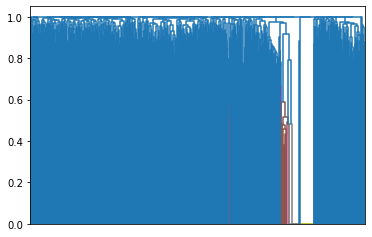

In [59]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

Z = linkage(matrix_sample.todense(), metric='cosine', method='complete')
_ = dendrogram(Z, no_labels=True) # Plot dentrogram chart


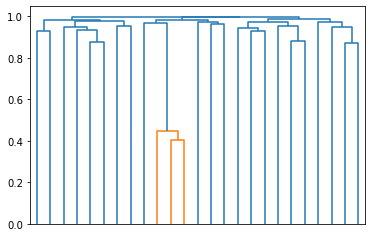

In [60]:
Z_ = linkage(matrix_sample.todense()[:25], metric='cosine', method='complete')
_ = dendrogram(Z_, no_labels=True) # Plot dentrogram chart


In [61]:
clusters = fcluster(Z, 0.99, criterion='distance') # Create flat clusters by distance threshold

print_clusters(matrix_sample, clusters)


Cluster: 1 (2 docs)
coral, decadal, ramsay, onoctober, algebraists, researcherswith, tenth, theholocene, seminar, solomon

Cluster: 2 (6 docs)
wavelet, jet, harmonic, jets, transverse, isotropic, subgrid, piv, frame, controlmethodologies

Cluster: 3 (7 docs)
bubble, gravitational, plume, envelope, radiation, ligo, inspiral, wave, binaries, star

Cluster: 4 (4 docs)
straightening, heat, repair, cores, damaged, effectofheat, definethelimiting, basedonexperience, applicationisprimarily, applicationforother

Cluster: 5 (13 docs)
helium, droplets, superfluid, liquid, 3he, multipole, molecules, atomic, areproposed, turbulence

Cluster: 6 (16 docs)
workshop, forensic, kdi, pbo, gaim, workshops, awards, lawyers, quebec, npp

Cluster: 7 (9 docs)
speckle, brain, tumors, ligand, mri, imaging, fmri, neuropeptides, synaptic, pk

Cluster: 8 (35 docs)
uml, polymer, biology, museum, figurines, yeara, umebproject, progressmonitored, ofbroadening, breaksand

Cluster: 9 (15 docs)
accessibility, cognition